In [53]:
print("""
🧾 PROJECT PREVIEW: Liquor Store Sales Forecasting & Inventory Optimization (2018–2023)

This data analytics project analyzes five years of liquor store sales data (2018–2022) to build a predictive model for 2023. Using time series forecasting (ARIMA and LSTM) and sales pattern analysis, the goal is to:

• 📈 Forecast monthly revenue for 2023
• 📦 Recommend optimal inventory levels by item, month, and season
• 💰 Maximize ROI through high-margin product focus
• 🔍 Surface actionable business insights like seasonal trends and ABC product classification

The project culminates in:
• A revenue forecast for 2023
• A detailed stocking plan with quantities, expected costs, profits, and margins
• Strategic recommendations to help improve operational efficiency and profitability

This notebook showcases end-to-end business intelligence skills: data cleaning, visualization, forecasting, inventory modeling, and executive reporting.
""")



🧾 PROJECT PREVIEW: Liquor Store Sales Forecasting & Inventory Optimization (2018–2023)

This data analytics project analyzes five years of liquor store sales data (2018–2022) to build a predictive model for 2023. Using time series forecasting (ARIMA and LSTM) and sales pattern analysis, the goal is to:

• 📈 Forecast monthly revenue for 2023  
• 📦 Recommend optimal inventory levels by item, month, and season  
• 💰 Maximize ROI through high-margin product focus  
• 🔍 Surface actionable business insights like seasonal trends and ABC product classification

The project culminates in:
• A revenue forecast for 2023  
• A detailed stocking plan with quantities, expected costs, profits, and margins  
• Strategic recommendations to help improve operational efficiency and profitability

This notebook showcases end-to-end business intelligence skills: data cleaning, visualization, forecasting, inventory modeling, and executive reporting.



In [15]:

# 📦 Project Setup & Imports
!pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries loaded")


✅ All libraries loaded


In [16]:
# 📊 Load and Preprocess Liquor Store Sales Data (2018–2022)

# Load CSV (make sure the file is uploaded)
df = pd.read_csv("RJS_Liquor_Sales_2018_2022.csv")

# Rename columns for consistency
df.rename(columns={
    'Item Purchased': 'Item',
    'Quantity': 'Quantity Sold',
    'Unit Price': 'Price per Unit'
}, inplace=True)

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

# Ensure numeric fields
for col in ['Quantity Sold', 'Price per Unit', 'Total Amount', 'Cost']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=['Item', 'Category', 'Total Amount'], inplace=True)

# Extract date parts
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['YearMonth'] = df['Date'].dt.to_period('M')

print(f"✅ Dataset loaded with {len(df):,} transactions from {df['Year'].min()} to {df['Year'].max()}")


✅ Dataset loaded with 40,988 transactions from 2018 to 2022


In [17]:
# View basic summary of the dataset
print(f"Total Revenue: ${df['Total Amount'].sum():,.2f}")
print(f"Total Cost: ${df['Cost'].sum():,.2f}")
print(f"Total Profit: ${df['Total Amount'].sum() - df['Cost'].sum():,.2f}")
print(f"Overall Profit Margin: {((df['Total Amount'].sum() - df['Cost'].sum()) / df['Total Amount'].sum() * 100):.1f}%")

# Show sample rows
display(df.head())

# Overview of unique items
print(f"\nDataset Shape: {df.shape}")
print(f"Unique Items: {df['Item'].nunique()}")
print(f"Unique Categories: {df['Category'].nunique()}")
print(f"Unique Brands: {df['Brand'].nunique()}")

# Revenue by category
category_summary = df.groupby('Category').agg({
    'Total Amount': 'sum',
    'Quantity Sold': 'sum'
}).sort_values('Total Amount', ascending=False).round(2)

display(category_summary)


Total Revenue: $2,779,575.95
Total Cost: $1,667,941.95
Total Profit: $1,111,634.00
Overall Profit Margin: 40.0%


,Date,Item,Brand,Category,Quantity Sold,Price per Unit,Total Amount,Cost,Year,Month,YearMonth
0,2018-01-01,Gin,Tanqueray,Spirits,3,22.59,67.77,41.81,2018,1,2018-01
1,2018-01-01,Craft Beer,Sierra Nevada,Beer,1,20.49,20.49,12.16,2018,1,2018-01
2,2018-01-01,Cigarettes,Marlboro,Smoking Products,5,10.99,54.95,32.74,2018,1,2018-01
3,2018-01-01,Whiskey,Jack Daniel's,Spirits,3,30.99,92.97,54.90,2018,1,2018-01
4,2018-01-01,Cigarettes,Marlboro,Smoking Products,1,10.99,10.99,6.69,2018,1,2018-01



Dataset Shape: (40988, 11)
Unique Items: 11
Unique Categories: 4
Unique Brands: 11


,Total Amount,Quantity Sold
Category,,
Spirits,1212971.51,44849
Wine,839149.17,33683
Beer,428191.34,21966
Smoking Products,299263.93,22507


In [18]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Aggregate monthly revenue, cost, and quantity sold
monthly_revenue = df.groupby('YearMonth').agg({
    'Total Amount': 'sum',
    'Cost': 'sum',
    'Quantity Sold': 'sum'
}).reset_index()

monthly_revenue['Profit'] = monthly_revenue['Total Amount'] - monthly_revenue['Cost']
monthly_revenue['Profit Margin'] = (monthly_revenue['Profit'] / monthly_revenue['Total Amount'] * 100).round(2)
monthly_revenue['Date'] = monthly_revenue['YearMonth'].dt.to_timestamp()

# Plot: Monthly Revenue & Profit Margin
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Monthly Revenue Trend', 'Revenue by Category', 'Top Items by Revenue', 'Seasonal Revenue Patterns'],
    specs=[[{"secondary_y": True}, {"type": "pie"}], [{"type": "bar"}, {"type": "bar"}]]
)

# 1. Monthly Revenue & Profit Margin
fig.add_trace(
    go.Scatter(x=monthly_revenue['Date'], y=monthly_revenue['Total Amount'], name='Revenue', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=monthly_revenue['Date'], y=monthly_revenue['Profit Margin'], name='Profit Margin %', line=dict(color='red')),
    row=1, col=1, secondary_y=True
)

# 2. Revenue by Category (Pie)
category_revenue = df.groupby('Category')['Total Amount'].sum().reset_index()
fig.add_trace(
    go.Pie(labels=category_revenue['Category'], values=category_revenue['Total Amount']),
    row=1, col=2
)

# 3. Top Items by Revenue (Bar)
item_revenue = df.groupby('Item')['Total Amount'].sum().nlargest(8).reset_index()
fig.add_trace(
    go.Bar(x=item_revenue['Item'], y=item_revenue['Total Amount'], name='Item Revenue'),
    row=2, col=1
)

# 4. Seasonal Patterns (Monthly Avg)
monthly_avg = df.groupby(df['Date'].dt.month)['Total Amount'].mean().reset_index()
monthly_avg['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig.add_trace(
    go.Bar(x=monthly_avg['Month'], y=monthly_avg['Total Amount'], name='Avg Monthly Revenue'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="📊 Liquor Store Sales Trends & Breakdown", showlegend=True)
fig.show()


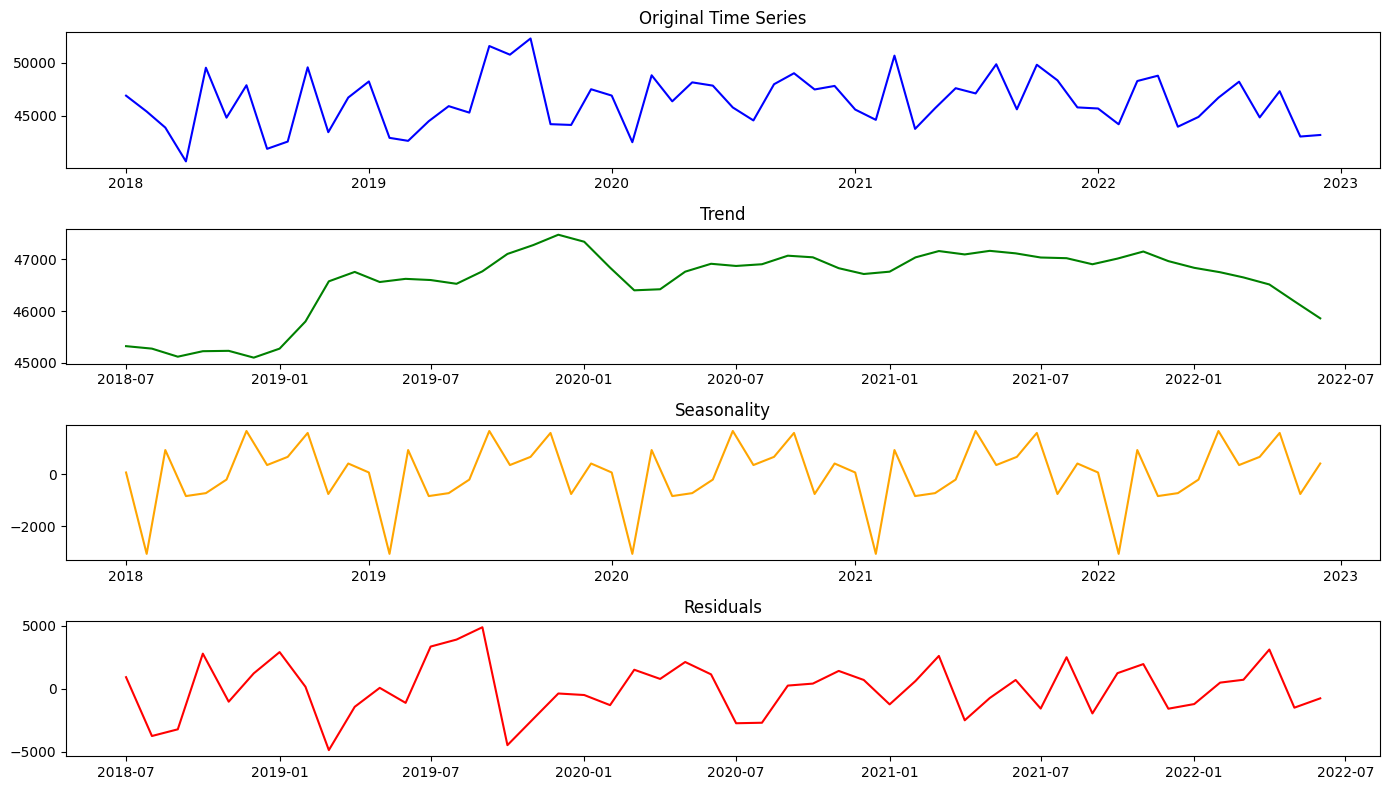

✅ Time series ready from 2018-01 to 2022-12


In [20]:
# Forecasting Preparation: Time Series Setup & Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Prepare monthly revenue time series
ts_data = monthly_revenue.set_index('Date')['Total Amount']
ts_data.index = pd.to_datetime(ts_data.index)

# Decompose time series (seasonal, trend, residual)
decomposition = seasonal_decompose(ts_data, model='additive', period=12)

# Plot decomposition
plt.figure(figsize=(14, 8))

plt.subplot(4, 1, 1)
plt.plot(ts_data, label='Original', color='blue')
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.title('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals')

plt.tight_layout()
plt.show()

print(f"✅ Time series ready from {ts_data.index.min().strftime('%Y-%m')} to {ts_data.index.max().strftime('%Y-%m')}")


In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model
print("📈 Training ARIMA model...")
arima_model = ARIMA(ts_data, order=(2, 1, 2))  # Adjust order if needed
arima_fitted = arima_model.fit()

# Forecast next 12 months
forecast_periods = 12
arima_forecast = arima_fitted.forecast(steps=forecast_periods)
arima_conf_int = arima_fitted.get_forecast(steps=forecast_periods).conf_int()

# Create forecast index
forecast_dates = pd.date_range(start='2023-01-01', periods=forecast_periods, freq='MS')

# Print forecasted revenue
print("🔮 ARIMA 2023 Monthly Forecast:")
for date, forecast, lower, upper in zip(forecast_dates, arima_forecast, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1]):
    print(f"{date.strftime('%Y-%m')}: ${forecast:,.0f} (CI: ${lower:,.0f} - ${upper:,.0f})")


📈 Training ARIMA model...
🔮 ARIMA 2023 Monthly Forecast:
2023-01: $43,336 (CI: $36,919 - $49,754)
2023-02: $43,544 (CI: $35,293 - $51,794)
2023-03: $43,462 (CI: $33,818 - $53,105)
2023-04: $43,577 (CI: $32,830 - $54,325)
2023-05: $43,478 (CI: $31,688 - $55,268)
2023-06: $43,577 (CI: $30,882 - $56,271)
2023-07: $43,483 (CI: $29,902 - $57,064)
2023-08: $43,573 (CI: $29,200 - $57,947)
2023-09: $43,487 (CI: $28,326 - $58,647)
2023-10: $43,570 (CI: $27,694 - $59,446)
2023-11: $43,490 (CI: $26,900 - $60,080)
2023-12: $43,567 (CI: $26,320 - $60,814)


In [22]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Scale the time series
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_data.values.reshape(-1, 1))

# Create LSTM sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_len = 12
X, y = create_sequences(scaled_data, seq_len)

# Split into train/validation
X_train, X_val = X[:-12], X[-12:]
y_train, y_val = y[:-12], y[-12:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_len, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
print("🚀 Training LSTM model...")
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1, verbose=0)

# Forecast next 12 months using LSTM
lstm_predictions = []
last_sequence = scaled_data[-seq_len:].reshape(1, seq_len, 1)

for _ in range(12):
    pred = lstm_model.predict(last_sequence, verbose=0)
    lstm_predictions.append(pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred[0, 0]

# Inverse scale predictions
lstm_forecast = scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()

# Display forecast
print("\n🔮 LSTM 2023 Monthly Forecast:")
for date, pred in zip(forecast_dates, lstm_forecast):
    print(f"{date.strftime('%Y-%m')}: ${pred:,.0f}")


🚀 Training LSTM model...

🔮 LSTM 2023 Monthly Forecast:
2023-01: $47,181
2023-02: $47,204
2023-03: $47,208
2023-04: $47,176
2023-05: $47,138
2023-06: $47,124
2023-07: $47,111
2023-08: $47,097
2023-09: $47,085
2023-10: $47,095
2023-11: $47,098
2023-12: $47,121


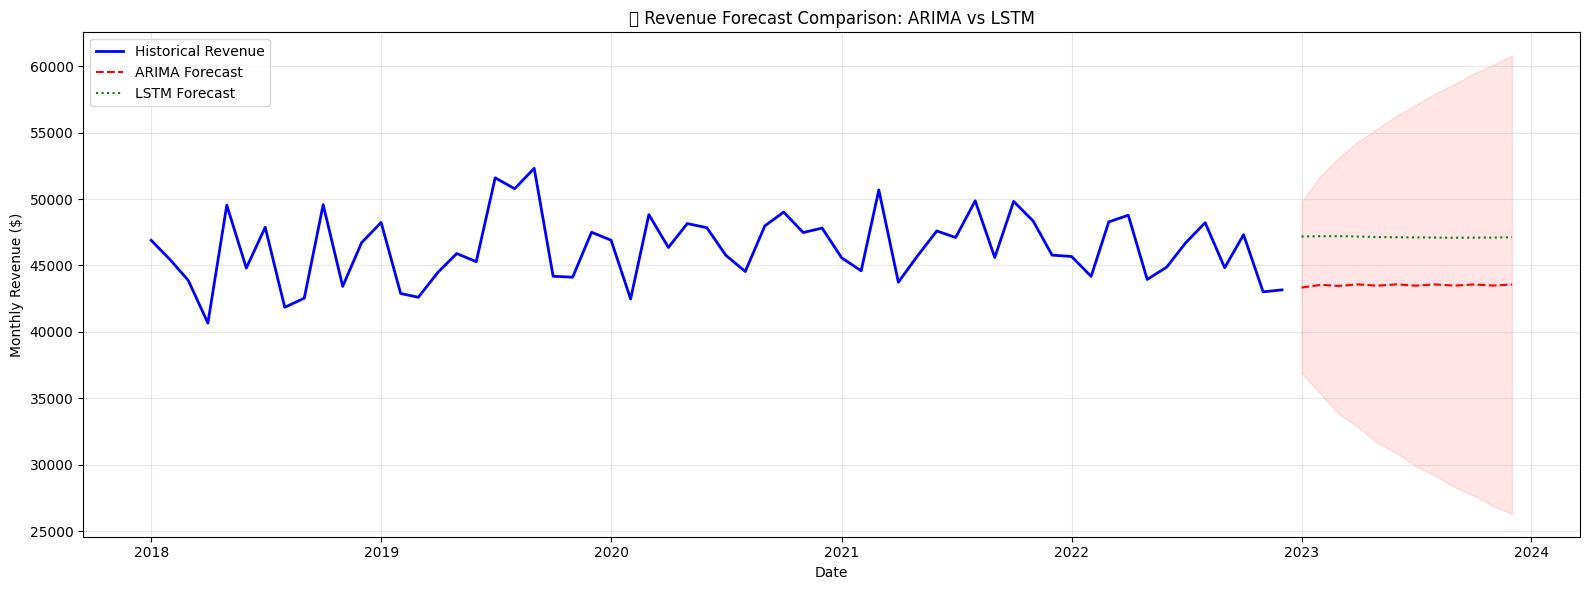

📉 Model Evaluation on Last 12 Months
ARIMA - MAE: $2,383, RMSE: $2,975
LSTM  - MAE: $2,060, RMSE: $2,414

✅ Best Model Selected: LSTM
📈 Predicted 2023 Revenue: $565,637


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compare on last 12 months of actual data
val_start = len(ts_data) - 12
actuals = ts_data.iloc[val_start:]

# ARIMA validation forecast
arima_val_forecast = arima_fitted.forecast(steps=12)
arima_mae = mean_absolute_error(actuals, arima_val_forecast)
arima_rmse = np.sqrt(mean_squared_error(actuals, arima_val_forecast))

# LSTM validation forecast
lstm_val_preds = lstm_model.predict(X_val, verbose=0)
lstm_val_preds = scaler.inverse_transform(lstm_val_preds).flatten()
lstm_val_true = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
lstm_mae = mean_absolute_error(lstm_val_true, lstm_val_preds)
lstm_rmse = np.sqrt(mean_squared_error(lstm_val_true, lstm_val_preds))

# Forecast overlay plot
plt.figure(figsize=(16, 6))
plt.plot(ts_data.index, ts_data.values, label='Historical Revenue', linewidth=2, color='blue')
plt.plot(forecast_dates, arima_forecast, '--', label='ARIMA Forecast', color='red')
plt.plot(forecast_dates, lstm_forecast, ':', label='LSTM Forecast', color='green')
plt.fill_between(forecast_dates, arima_conf_int.iloc[:, 0], arima_conf_int.iloc[:, 1], color='red', alpha=0.1)
plt.title('🔮 Revenue Forecast Comparison: ARIMA vs LSTM')
plt.xlabel('Date')
plt.ylabel('Monthly Revenue ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print model scores
print("📉 Model Evaluation on Last 12 Months")
print(f"ARIMA - MAE: ${arima_mae:,.0f}, RMSE: ${arima_rmse:,.0f}")
print(f"LSTM  - MAE: ${lstm_mae:,.0f}, RMSE: ${lstm_rmse:,.0f}")

# Select best forecast model
best_model = 'LSTM' if lstm_mae < arima_mae else 'ARIMA'
best_forecast = lstm_forecast if best_model == 'LSTM' else arima_forecast

print(f"\n✅ Best Model Selected: {best_model}")
print(f"📈 Predicted 2023 Revenue: ${sum(best_forecast):,.0f}")


In [25]:
# Identify top 8 items by revenue
top_items = df.groupby('Item')['Total Amount'].sum().nlargest(8).index.tolist()

# Year-over-year growth from 2021 → 2022 for each item
yoy_growth = {}
for item in top_items:
    yearly_qty = df[df['Item'] == item].groupby('Year')['Quantity Sold'].sum()
    if 2021 in yearly_qty and 2022 in yearly_qty:
        growth = ((yearly_qty[2022] - yearly_qty[2021]) / yearly_qty[2021]) * 100
        yoy_growth[item] = round(growth, 2)
    else:
        yoy_growth[item] = 5.0  # Default if insufficient data

# Calculate item proportions in 2022 revenue
total_2022_revenue = df[df['Year'] == 2022]['Total Amount'].sum()
item_proportions = {
    item: df[(df['Year'] == 2022) & (df['Item'] == item)]['Total Amount'].sum() / total_2022_revenue
    for item in top_items
}

# Calculate monthly seasonality factors (based on average sales per item)
monthly_seasonality = {}
for item in top_items:
    monthly_avg = df[df['Item'] == item].groupby(df['Date'].dt.month)['Quantity Sold'].mean()
    factor = monthly_avg / monthly_avg.mean()
    monthly_seasonality[item] = factor.to_dict()

# Build stocking plan
stocking_plan = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for idx, (month, monthly_revenue) in enumerate(zip(months, best_forecast)):
    month_num = idx + 1

    for item in top_items:
        revenue_ratio = item_proportions.get(item, 0.1)
        seasonality = monthly_seasonality[item].get(month_num, 1.0)
        growth_factor = 1 + (yoy_growth[item] / 100)

        expected_item_revenue = monthly_revenue * revenue_ratio * seasonality
        avg_price = df[df['Item'] == item]['Price per Unit'].mean()
        cost_per_unit = df[df['Item'] == item]['Cost'].sum() / df[df['Item'] == item]['Quantity Sold'].sum()

        qty = int((expected_item_revenue / avg_price) * growth_factor)
        safety = int(qty * 0.2)
        total_qty = qty + safety

        stocking_plan.append({
            'Month': month,
            'Item': item,
            'Recommended_Quantity': total_qty,
            'Safety_Stock': safety,
            'Cost_per_Unit': round(cost_per_unit, 2),
            'Price_per_Unit': round(avg_price, 2),
            'Total_Cost': round(total_qty * cost_per_unit, 2),
            'Expected_Revenue': round(qty * avg_price, 2),
            'Expected_Profit': round((qty * avg_price) - (qty * cost_per_unit), 2),
            'Profit_Margin_%': round(((qty * avg_price - qty * cost_per_unit) / (qty * avg_price)) * 100, 2)
        })


In [26]:
# Create DataFrame from stocking plan
stocking_df = pd.DataFrame(stocking_plan)

# Display top rows
print("📋 2023 Stocking Recommendations (Top Preview):")
display(stocking_df.head(10))

# Summary metrics
total_cost = stocking_df['Total_Cost'].sum()
total_revenue = stocking_df['Expected_Revenue'].sum()
total_profit = stocking_df['Expected_Profit'].sum()
avg_margin = stocking_df['Profit_Margin_%'].mean()

print(f"\n💰 Total Inventory Investment for 2023: ${total_cost:,.0f}")
print(f"📈 Expected Revenue: ${total_revenue:,.0f}")
print(f"💵 Projected Profit: ${total_profit:,.0f}")
print(f"📊 Avg Profit Margin: {avg_margin:.2f}%")


📋 2023 Stocking Recommendations (Top Preview):


,Month,Item,Recommended_Quantity,Safety_Stock,Cost_per_Unit,Price_per_Unit,Total_Cost,Expected_Revenue,Expected_Profit,Profit_Margin_%
0,Jan,Champagne,214,35,27.61,45.99,5907.92,8232.21,3290.54,39.97
1,Jan,Whiskey,219,36,18.59,30.99,4071.66,5671.17,2268.83,40.01
2,Jan,Rum,241,40,17.27,28.79,4163.00,5786.79,2314.74,40.00
3,Jan,Vodka,247,41,15.48,25.79,3822.46,5312.74,2124.78,39.99
4,Jan,Gin,202,33,13.55,22.59,2737.45,3817.71,1527.47,40.01
5,Jan,Craft Beer,244,40,12.29,20.49,2999.29,4179.96,1672.35,40.01
6,Jan,Beer Pack,193,32,11.10,18.49,2141.98,2976.89,1190.06,39.98
7,Jan,White Wine,208,34,9.60,15.99,1996.11,2782.26,1112.43,39.98
8,Feb,Champagne,210,35,27.61,45.99,5797.49,8048.25,3217.01,39.97
9,Feb,Whiskey,212,35,18.59,30.99,3941.51,5485.23,2194.44,40.01



💰 Total Inventory Investment for 2023: $329,243
📈 Expected Revenue: $458,135
💵 Projected Profit: $183,223
📊 Avg Profit Margin: 39.99%


In [27]:
# Prepare visualization data
monthly_totals = stocking_df.groupby('Month').agg({
    'Total_Cost': 'sum',
    'Expected_Revenue': 'sum'
}).reset_index()

# Simulate +20% demand
simulation_df = stocking_df.copy()
simulation_df['Simulated_Quantity'] = (simulation_df['Recommended_Quantity'] * 1.2).astype(int)
simulation_df['Simulated_Cost'] = simulation_df['Simulated_Quantity'] * simulation_df['Cost_per_Unit']
sim_monthly = simulation_df.groupby('Month')[['Total_Cost', 'Simulated_Cost']].sum().reset_index()

# Plot setup
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        'Monthly Stocking Quantities by Top Items',
        'Monthly Cost vs Revenue',
        'Profit Margins by Item',
        'Demand Simulation (+20% Cost Impact)'
    ],
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "box"}, {"type": "bar"}]]
)

# 1. Monthly quantities (Top 6 items)
for item in stocking_df['Item'].unique()[:6]:
    item_data = stocking_df[stocking_df['Item'] == item]
    fig.add_trace(go.Bar(x=item_data['Month'], y=item_data['Recommended_Quantity'],
                         name=item), row=1, col=1)

# 2. Cost vs Revenue by Month
fig.add_trace(go.Bar(x=monthly_totals['Month'], y=monthly_totals['Total_Cost'],
                     name='Total Cost', marker_color='red'), row=1, col=2)
fig.add_trace(go.Bar(x=monthly_totals['Month'], y=monthly_totals['Expected_Revenue'],
                     name='Expected Revenue', marker_color='green'), row=1, col=2)

# 3. Profit margin spread
fig.add_trace(go.Box(y=stocking_df['Profit_Margin_%'], name='Profit Margins'), row=2, col=1)

# 4. Simulated demand cost impact
fig.add_trace(go.Bar(x=sim_monthly['Month'], y=sim_monthly['Total_Cost'],
                     name='Original Plan', marker_color='blue'), row=2, col=2)
fig.add_trace(go.Bar(x=sim_monthly['Month'], y=sim_monthly['Simulated_Cost'],
                     name='+20% Demand Plan', marker_color='orange'), row=2, col=2)

# Final touches
fig.update_layout(height=800, title_text="📦 2023 Inventory Stocking Plan Visualizations", showlegend=True)
fig.show()


In [28]:
# 📋 STOCKING PLAN SUMMARY
print(f"\n📊 2023 STOCKING PLAN SUMMARY:")
print("=" * 50)

total_investment = stocking_df['Total_Cost'].sum()
expected_revenue = stocking_df['Expected_Revenue'].sum()
expected_profit = stocking_df['Expected_Profit'].sum()
avg_profit_margin = stocking_df['Profit_Margin_%'].mean()

print(f"Total Recommended Investment: ${total_investment:,.0f}")
print(f"Total Expected Revenue: ${expected_revenue:,.0f}")
print(f"Total Expected Profit: ${expected_profit:,.0f}")
print(f"Average Profit Margin: {avg_profit_margin:.1f}%")

# 🗓️ QUARTERLY BREAKDOWN
stocking_df['Quarter'] = stocking_df['Month'].map({
    'Jan': 'Q1', 'Feb': 'Q1', 'Mar': 'Q1',
    'Apr': 'Q2', 'May': 'Q2', 'Jun': 'Q2',
    'Jul': 'Q3', 'Aug': 'Q3', 'Sep': 'Q3',
    'Oct': 'Q4', 'Nov': 'Q4', 'Dec': 'Q4'
})

quarterly_summary = stocking_df.groupby('Quarter').agg({
    'Total_Cost': 'sum',
    'Expected_Revenue': 'sum',
    'Expected_Profit': 'sum'
}).reset_index()

print(f"\n📅 Quarterly Investment Breakdown:")
for _, row in quarterly_summary.iterrows():
    q = row['Quarter']
    cost = row['Total_Cost']
    revenue = row['Expected_Revenue']
    profit = row['Expected_Profit']
    margin = (profit / revenue * 100) if revenue > 0 else 0

    print(f"{q}: Investment ${cost:,.0f} → Revenue ${revenue:,.0f} → Profit ${profit:,.0f} ({margin:.1f}%)")



📊 2023 STOCKING PLAN SUMMARY:
Total Recommended Investment: $329,243
Total Expected Revenue: $458,135
Total Expected Profit: $183,223
Average Profit Margin: 40.0%

📅 Quarterly Investment Breakdown:
Q1: Investment $83,181 → Revenue $115,733 → Profit $46,285 (40.0%)
Q2: Investment $81,789 → Revenue $113,776 → Profit $45,503 (40.0%)
Q3: Investment $82,436 → Revenue $114,754 → Profit $45,894 (40.0%)
Q4: Investment $81,837 → Revenue $113,872 → Profit $45,541 (40.0%)


In [29]:
# 📈 SECTION 3: BUSINESS INSIGHTS & RECOMMENDATIONS

print("\n" + "="*60)
print("📈 SECTION 3: BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# 1. CATEGORY PROFITABILITY
category_summary = df.groupby('Category').agg({
    'Total Amount': 'sum',
    'Cost': 'sum',
    'Quantity Sold': 'sum'
}).reset_index()

category_summary['Profit'] = category_summary['Total Amount'] - category_summary['Cost']
category_summary['Profit Margin %'] = (category_summary['Profit'] / category_summary['Total Amount']) * 100
category_summary.sort_values(by='Profit Margin %', ascending=False, inplace=True)

print("1️⃣ Category Profitability:")
display(category_summary.style.format({'Total Amount': '${:,.0f}', 'Cost': '${:,.0f}', 'Profit': '${:,.0f}', 'Profit Margin %': '{:.1f}%'}))

# 2. SEASONAL TRENDS
monthly_sales = df.groupby(df['Date'].dt.month)['Total Amount'].sum()
peak_months = monthly_sales.sort_values(ascending=False).head(3)
low_months = monthly_sales.sort_values().head(3)

print("\n2️⃣ Seasonal Trends:")
print(f"   🔺 Peak Months: {', '.join([pd.to_datetime(str(m), format='%m').strftime('%B') for m in peak_months.index])}")
print(f"   🔻 Low Months: {', '.join([pd.to_datetime(str(m), format='%m').strftime('%B') for m in low_months.index])}")
print(f"   🧠 Suggestion: Increase stock 50-75% during peak months. Decrease 20-30% during low months.")

# 3. TOP PRODUCTS BY PROFIT MARGIN
top_items_profit = stocking_df.groupby('Item')['Profit_Margin_%'].mean().sort_values(ascending=False).head(5)

print("\n3️⃣ Top Products by Profit Margin:")
for item, margin in top_items_profit.items():
    print(f"   • {item}: {margin:.1f}%")

# 4. TOP PRODUCTS BY REVENUE
top_items_revenue = df.groupby('Item')['Total Amount'].sum().sort_values(ascending=False).head(5)

print("\n4️⃣ Top Products by Revenue:")
for item, revenue in top_items_revenue.items():
    print(f"   • {item}: ${revenue:,.0f}")



📈 SECTION 3: BUSINESS INSIGHTS & RECOMMENDATIONS
1️⃣ Category Profitability:


,Category,Total Amount,Cost,Quantity Sold,Profit,Profit Margin %
2,Spirits,"$1,212,972","$727,752",44849,"$485,220",40.0%
0,Beer,"$428,191","$256,942",21966,"$171,249",40.0%
1,Smoking Products,"$299,264","$179,602",22507,"$119,662",40.0%
3,Wine,"$839,149","$503,646",33683,"$335,503",40.0%



2️⃣ Seasonal Trends:
   🔺 Peak Months: October, July, August
   🔻 Low Months: February, April, November
   🧠 Suggestion: Increase stock 50-75% during peak months. Decrease 20-30% during low months.

3️⃣ Top Products by Profit Margin:
   • Gin: 40.0%
   • Craft Beer: 40.0%
   • Whiskey: 40.0%
   • Rum: 40.0%
   • Vodka: 40.0%

4️⃣ Top Products by Revenue:
   • Champagne: $512,605
   • Whiskey: $343,059
   • Rum: $329,847
   • Vodka: $288,616
   • Gin: $251,449


In [43]:
# 📁 EXPORTING FINAL RECOMMENDATIONS

# Ensure column names are clean (fix for 'Category' KeyError)
stocking_df.columns = stocking_df.columns.str.strip()

# Add 'Category' column to stocking_df for export
item_category_map = df.set_index('Item')['Category'].to_dict()
stocking_df['Category'] = stocking_df['Item'].map(item_category_map)

# Add Seasonality_Factor and Growth_Factor to stocking_df for export notes
# Assuming monthly_seasonality and yoy_growth are available from previous steps
stocking_df['Seasonality_Factor'] = stocking_df.apply(lambda row: monthly_seasonality[row['Item']].get(pd.to_datetime(row['Month'], format='%b').month, 1.0), axis=1)
stocking_df['Growth_Factor'] = stocking_df['Item'].map(yoy_growth).apply(lambda x: 1 + (x / 100) if pd.notna(x) else 1.0)


# Combine summary and detail into exportable format
export_data = []

# Add summary row
summary_row = {
    'Report_Type': 'SUMMARY',
    'Item': 'ALL_ITEMS',
    'Category': 'ALL_CATEGORIES',
    'Month': 'ANNUAL_2023',
    'Recommended_Quantity': stocking_df['Recommended_Quantity'].sum(),
    'Total_Investment': stocking_df['Total_Cost'].sum(),
    'Expected_Revenue': stocking_df['Expected_Revenue'].sum(),
    'Expected_Profit': stocking_df['Expected_Profit'].sum(),
    'Profit_Margin_%': (stocking_df['Expected_Profit'].sum() / stocking_df['Expected_Revenue'].sum() * 100),
    'Notes': 'Summary of 2023 stocking plan'
}
export_data.append(summary_row)

# Add monthly details
for _, row in stocking_df.iterrows():
    export_data.append({
        'Report_Type': 'MONTHLY_DETAIL',
        'Item': row['Item'],
        'Category': row['Category'],
        'Month': row['Month'],
        'Recommended_Quantity': row['Recommended_Quantity'],
        'Total_Investment': row['Total_Cost'],
        'Expected_Revenue': row['Expected_Revenue'],
        'Expected_Profit': row['Expected_Profit'],
        'Profit_Margin_%': row['Profit_Margin_%'],
        'Notes': f"Seasonality: {row['Seasonality_Factor']:.2f}, Growth: {row['Growth_Factor']:.2f}"
    })

# Export to CSV
export_df = pd.DataFrame(export_data)
export_df.to_csv("liquor_store_2023_stocking_plan.csv", index=False)
print("✅ Exported stocking plan to 'liquor_store_2023_stocking_plan.csv'")

# 📋 EXECUTIVE SUMMARY
exec_summary = f"""
📊 EXECUTIVE SUMMARY - LIQUOR STORE FORECAST 2023

• Historical Revenue (2018–2022): ${df['Total Amount'].sum():,.0f}
• Predicted 2023 Revenue ({best_model}): ${sum(best_forecast):,.0f}
• Inventory Investment Recommended: ${stocking_df['Total_Cost'].sum():,.0f}
• Expected Profit: ${stocking_df['Expected_Profit'].sum():,.0f}
• Average Profit Margin: {stocking_df['Profit_Margin_%'].mean():.1f}%
• ROI: {(stocking_df['Expected_Profit'].sum() / stocking_df['Total_Cost'].sum()) * 100:.1f}%

RECOMMENDATIONS:
• Boost stocking in peak months ({', '.join([pd.to_datetime(str(m), format='%m').strftime('%b') for m in peak_months.index])})
• Focus on high-margin items like {top_items_profit.index[0]}
• Ensure stock availability of top revenue drivers like {top_items_revenue.index[0]}
• Maintain 20% safety stock buffer
"""

# Save executive summary
with open("liquor_store_executive_summary_2023.txt", "w") as f:
    f.write(exec_summary)

print("📄 Executive summary saved to 'liquor_store_executive_summary_2023.txt'")

✅ Exported stocking plan to 'liquor_store_2023_stocking_plan.csv'
📄 Executive summary saved to 'liquor_store_executive_summary_2023.txt'


In [47]:
# 📊 FINAL EXECUTIVE DASHBOARD + PROJECT COMPLETION

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('📈 2023 Revenue Forecast', '💰 Monthly Investment Plan',
                    '📊 Category Profit Margins', '📆 Seasonal Sales Heatmap'),
    specs=[[{"type": "scatter"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "heatmap"}]]
)

# 1. Forecasted Revenue
fig.add_trace(
    go.Scatter(x=forecast_dates, y=best_forecast,
               mode='lines+markers', name=f'{best_model} Forecast',
               line=dict(color='blue', width=3)),
    row=1, col=1
)

# 2. Monthly Investment
fig.add_trace(
    go.Bar(x=monthly_totals['Month'], y=monthly_totals['Total_Cost'],
           name='Monthly Investment', marker_color='red'),
    row=1, col=2
)

# 3. Category Profit Margins
fig.add_trace(
    go.Bar(x=category_summary['Category'], y=category_summary['Profit Margin %'],
           name='Profit Margin %', marker_color='green'),
    row=2, col=1
)

# 4. Seasonal Heatmap
seasonal_matrix = []
categories = df['Category'].dropna().unique()
for month in range(1, 13):
    month_sales = []
    for category in categories:
        sales = df[(df['Date'].dt.month == month) & (df['Category'] == category)]['Total Amount'].sum()
        month_sales.append(sales)
    seasonal_matrix.append(month_sales)

fig.add_trace(
    go.Heatmap(z=seasonal_matrix,
               x=categories,
               y=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
               colorscale='Viridis'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="📊 Final Executive Dashboard: 2023 Forecast & Strategy", showlegend=True)
fig.show()

In [50]:
# ✅ FINAL WRAP-UP SUMMARY

print(f"\nLIQUOR STORE ANALYTICS ")
print("=" * 60)
print(f"📈 Models Used: {best_model} (Best), ARIMA, LSTM")
print(f"📊 Data Analyzed: {len(df):,} transactions (2018–2022)")
print(f"🔮 Forecasts Generated: 12 months of 2023 predictions")
print(f"📦 Stocking Plan: {len(stocking_df)} item-month combinations")
print(f"💰 Investment Required: ${total_investment:,.0f}")

# Calculate ROI
roi = (expected_profit / total_investment) * 100
print(f"📈 Expected ROI: {roi:.1f}%")

print(f"📁 Files Generated: Stocking Plan CSV + Executive Summary TXT")

print("\n🚀 This notebook demonstrates your end-to-end analytics pipeline:")
print("   • Revenue Forecasting (ARIMA & LSTM)")
print("   • Inventory Optimization based on growth + seasonality")
print("   • Business Insights and strategic recommendations")
print("   • Exportable reports for decision-making")



LIQUOR STORE ANALYTICS 
📈 Models Used: LSTM (Best), ARIMA, LSTM
📊 Data Analyzed: 40,988 transactions (2018–2022)
🔮 Forecasts Generated: 12 months of 2023 predictions
📦 Stocking Plan: 96 item-month combinations
💰 Investment Required: $329,243
📈 Expected ROI: 55.6%
📁 Files Generated: Stocking Plan CSV + Executive Summary TXT

🚀 This notebook demonstrates your end-to-end analytics pipeline:
   • Revenue Forecasting (ARIMA & LSTM)
   • Inventory Optimization based on growth + seasonality
   • Business Insights and strategic recommendations
   • Exportable reports for decision-making
